In [32]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.finite_differences as fd

import module.sampler as samplers

In [33]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

In [47]:
solver = fd.Solver(N = 50, L = 1)

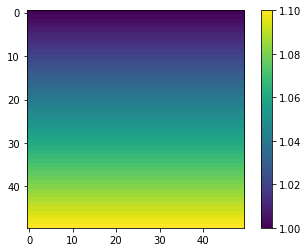

In [48]:
k = solver.xx*0.1 + 1
plt.imshow(k)
plt.colorbar()

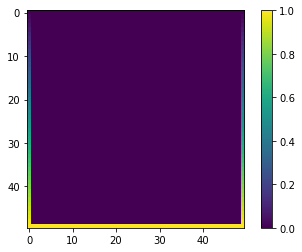

In [50]:
dirichlet = np.zeros((solver.N,solver.N))
dirichlet[0,:] = 0
dirichlet[-1, :] = 1
dirichlet[:, 0] = solver.x
dirichlet[:, -1] = solver.x
dirichlet = jnp.array(dirichlet)

plt.imshow(dirichlet)
plt.colorbar()

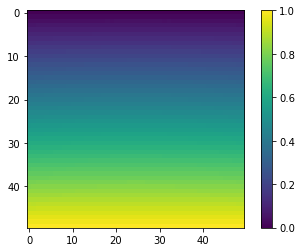

In [51]:
T = solver.solve(k, dirichlet)
plt.imshow(T)
plt.colorbar()

In [241]:
def getNeumann(T, k):
    T_flat = T.flatten()
    jx = jnp.diag(k.flatten()) @ solver.Dx @ T_flat
    jy = jnp.diag(k.flatten()) @ solver.Dy @ T_flat

    jx = jx.reshape((solver.N, solver.N))
    jy = jy.reshape((solver.N, solver.N))

    return -jx[0,:], jx[-1,:], -jy[:,0], jy[:, -1]

In [242]:
@jax.jit
def log_prob(k, dirichlet, neumann):
    T = solver.solve(k, dirichlet)

    a,b,c,d = getNeumann(T, k)

    acc = jnp.sum((a-neumann[0])**2) + jnp.sum((b-neumann[1])**2) + jnp.sum((c-neumann[2])**2) + jnp.sum((d-neumann[3])**2)
    acc *= solver.dx

    return -acc

In [243]:
neumann = getNeumann(T, k)

## Gradient Optimisation

In [607]:
class FourierNoise:
    def __init__(self, N):
        self.N = N
        yy, xx = jnp.meshgrid(jnp.linspace(0,1,self.N), jnp.linspace(0,1,self.N))
        self.gauss = self.gaussian(xx - 0.5, yy - 0.5)
        self.fgauss = jnp.abs(jnp.fft.fft2(self.gauss))  # use to mask

    def gaussian(self, x, y):
        return jnp.exp(-(x**2+ y**2)**2*400**2) 
    
    def toImage(self, fim):
        return jnp.abs(jnp.fft.ifft2(fim * self.fgauss))

In [668]:
fn = FourierNoise(100)

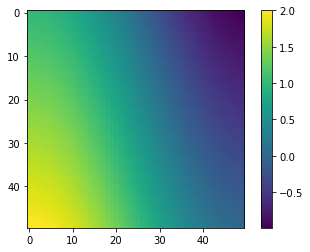

In [677]:
target = solver.xx + jnp.cos(solver.yy*3)
plt.imshow(target)
plt.colorbar()

In [678]:
@jax.jit
def loss(k_fourier):
    k = fn.toImage(k_fourier)[0:50,0:50]
    return jnp.sum((target - k)**2)

In [679]:
g = jax.jit(jax.value_and_grad(loss))

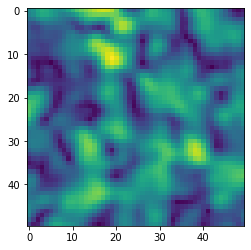

In [680]:
k_fourier = jax.random.normal(key, (100,100))
plt.imshow(fn.toImage(k_fourier)[0:50,0:50])
# plt.colorbar()
key, _ = jax.random.split(key)

In [681]:
err = []

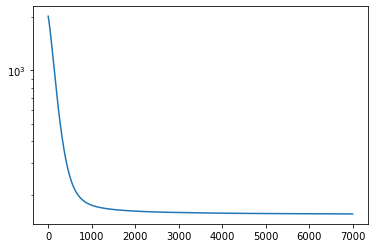

In [700]:
for i in range(500):
    val, grad = g(k_fourier)
    err.append(val)
    k_fourier = k_fourier - 0.01*grad


plt.plot(err)
plt.yscale("log")

In [701]:
err[-1]

Array(156.15851, dtype=float32)

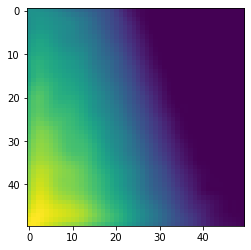

In [703]:
plt.imshow(fn.toImage(k_fourier)[0:50,0:50])

## MCMC

In [851]:
class Sampler(samplers.MCMC):
    def __init__(self, N, logprob):
        super().__init__((N, N), logprob)

        self.N = N
        yy, xx = jnp.meshgrid(jnp.linspace(0,1,N), jnp.linspace(0,1,N))
        self.gauss = self.gaussian(xx - 0.5, yy - 0.5)
        self.fgauss = jnp.abs(jnp.fft.fft2(self.gauss))  # use to mask
        self.sigma = 0.01

    def gaussian(self, x, y):
        return jnp.exp(-(x**2+ y**2)**2*20**2) 

    def propose_inital(self, key):
        fim = jax.random.normal(key, shape = (self.N, self.N)) * self.fgauss
        return fim

    def propose(self, key, k_fourier):
        key, subkey = jax.random.split(key)

        step = jax.random.normal(key, shape = (self.N, self.N)) * self.sigma
        fim = k_fourier + step * self.fgauss

        return subkey, fim
    
    def toImage(self, fim):
        return jnp.abs(jnp.fft.ifft2(fim))

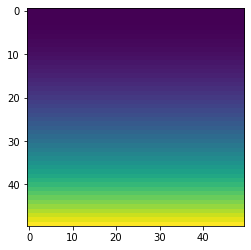

In [852]:
N = 100
yy, xx = jnp.meshgrid(jnp.linspace(0,1,N), jnp.linspace(0,1,N))

target = xx[0:50,0:50]**2

def logprob(fim):
    im = jnp.abs(jnp.fft.ifft2(fim)[0:50,0:50])
    return -jnp.sum((target - im)**2, axis = (-1,-2)) * 10


plt.imshow(target)

In [853]:
sampler = Sampler(N = 100, logprob = logprob)

In [854]:
@jax.jit
def sample(initial):
    samples, ratio = sampler.sample(key, initial, 15000)

    return samples, ratio

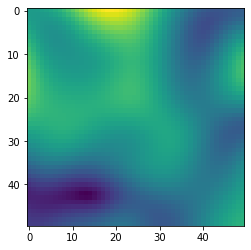

In [845]:
init = sampler.propose_inital(key)
plt.imshow(sampler.toImage(init)[0:50,0:50])

In [855]:
samples, ratio = sample(samples[-1])
print(ratio)

0.7758


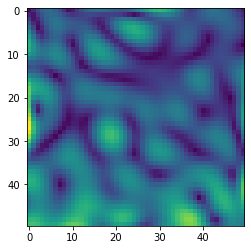

In [857]:
plt.imshow(sampler.toImage(jnp.mean(samples, axis = 0))[0:50,0:50])